In [ ]:
from google.colab import drive
drive.mount('/content/drive')053065ba239e3421d1b2cbec55e3f177a21d6829

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Imports
import re
from datetime import datetime
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import json
import ast
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
#@title Load data
commits = pd.read_csv('/content/drive/My Drive/AI Index Visualization Project/DATASETS/Github/Frameworks/Pytorch/version-1/commits.csv', parse_dates=True)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (59) have mixed types.Specify dtype option on import or set low_memory=False.



## Data Preprocessing

In [ ]:
#@title Preprocess
commits['date'] =  pd.to_datetime(commits['commit.committer.date'])
commits['date'] =  pd.to_datetime(commits['date'], utc=True)
commits['commit_date'] = commits['date'].dt.date
commits['commit_week'] = commits['date'].dt.week
commits['commit_hour'] = commits['date'].dt.hour
commits['commit_month'] = commits['date'].dt.month
commits['commit_year'] = commits['date'].dt.year
commits = commits[['sha', 'author.login', 'commit_date', 'commit_hour', 'commit_month', 'commit_year']]
commits.head()

,sha,author.login,commit_date,commit_hour,commit_month,commit_year
0,b35cdc5200af963e410c0a25400fd07f30b89bca,iseeyuan,2020-06-28,23,6,2020
1,b4db529352eca5b096c883c31c50adbb0c88c9aa,jeongukjae,2020-06-28,20,6,2020
2,502ec8f7f76619e6cbb1efb0e23eb8c5438daed2,ngimel,2020-06-28,5,6,2020
3,5377827b3ec726c3906d73a142ffd81c13f465e4,iseeyuan,2020-06-28,5,6,2020
4,521722751f9f29ae0334af88d090cbe3cab2a117,mrshenli,2020-06-28,3,6,2020


## Data Analysis

In [ ]:
#@title Commits by hours
commits['author.login'].unique().size
commits_by_hour = commits.groupby('commit_hour')[['sha']].count()
commits_by_hour = commits_by_hour.rename(columns = {'sha': 'commit_count'})
fig = go.Figure([go.Bar(
    x=commits_by_hour.index, 
    y=commits_by_hour.commit_count, 
    text=commits_by_hour.commit_count, 
    textposition='auto')])
fig.update_layout(
    title = 'Commits by Hour', 
    xaxis_title = 'Hour', 
    yaxis_title = 'Commits Count', 
    xaxis_tickmode = 'linear')
fig.show()

In [ ]:
#@title Commits by date
commits_by_day = commits.groupby('commit_date')[['sha']].count()
commits_by_day = commits_by_day.rename(columns = {'sha': 'commit_count'})
fig = go.Figure([go.Scatter(
    x=commits_by_day.index, 
    y=commits_by_day.commit_count, 
    text=commits_by_day.commit_count, 
    fill='tozeroy')])
fig.update_layout(
    title = 'Commits by Date', 
    xaxis_title = 'Date', 
    yaxis_title = 'Commits Count')
fig.show()

In [ ]:
#@title Average Daily Commits by Year
yearly_commits = commits.groupby('commit_year')[['sha']].count()
yearly_commits = yearly_commits.rename(columns = {'sha': 'commits_count'})
yearly_commits['daily_avg'] = yearly_commits['commits_count']/365
fig = go.Figure([go.Scatter(
    x=yearly_commits.index, 
    y=yearly_commits.daily_avg, 
    text=yearly_commits.daily_avg
)])
fig.update_layout(
    title = 'Average Daily Commits by Year', 
    xaxis_title = 'Year', 
    yaxis_title = 'Average Number of Commits',
    xaxis_tickmode = 'linear')
fig.show()

In [ ]:
#@title Commits by Autors 
commits_by_author = commits.groupby('author.login')[['sha']].count()
commits_by_author = commits_by_author.rename(columns = {'sha': 'commit_count'})
commits_by_author = commits_by_author.sort_values(by='commit_count', ascending=False)
top_authors = commits_by_author.head(30)
fig = go.Figure([go.Bar(
    x=top_authors.index, 
    y=top_authors.commit_count)])
fig.update_layout(
    title = 'Top Committers', 
    xaxis_title = 'Author', 
    yaxis_title = 'Commits Count', 
    xaxis_tickmode = 'linear',
    xaxis_tickangle=-40)
fig.show()

## Organization

In [ ]:
#@title Organization
organization = "pytorch" #@param ["pytorch","Keras","Tensorflow"]
repos = pd.read_csv('/content/drive/My Drive/AI Index Visualization Project/DATASETS/Github/Frameworks/Pytorch/repos_info.csv')
commits = pd.read_csv('/content/drive/My Drive/AI Index Visualization Project/DATASETS/Github/Frameworks/Pytorch/commits_info.csv')


Text(0.5, 1.0, 'Commits per repository')

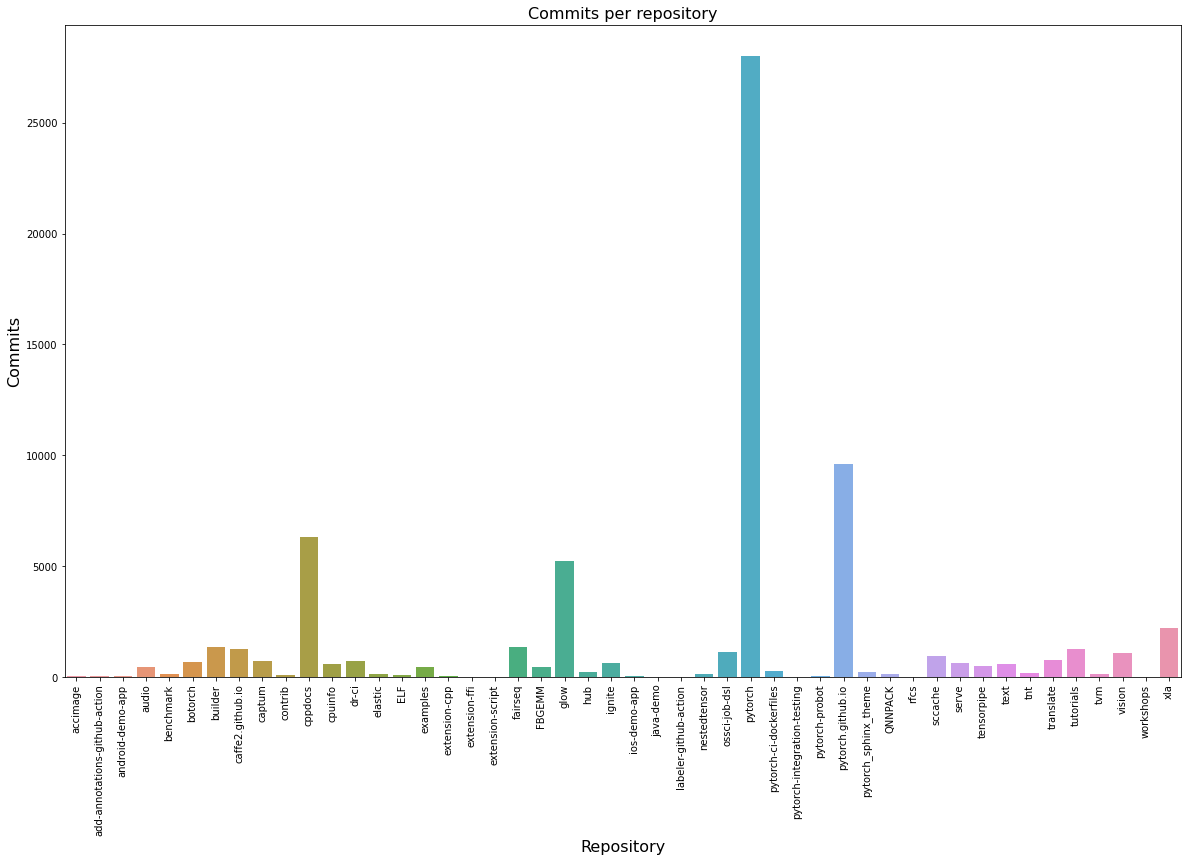

In [ ]:
#@title Commits per repository
commits_count = pd.DataFrame(pd.merge(repos, 
         commits, 
         left_on='Id', 
         right_on='Repo Id', 
         how = 'left').groupby('Id').size().reset_index())
commits_count.columns = ['Id', 'Commits count']
repos = pd.merge(repos, commits_count, on = 'Id')
plt.figure(figsize = (20, 12))
sns.barplot(repos['Name'], repos['Commits count'])
plt.xticks(rotation = 90)
plt.xlabel("Repository", fontsize = 16)
plt.ylabel("Commits", fontsize = 16)
plt.title("Commits per repository", fontsize = 16)


Text(0.5, 1.0, 'Commits in each year')

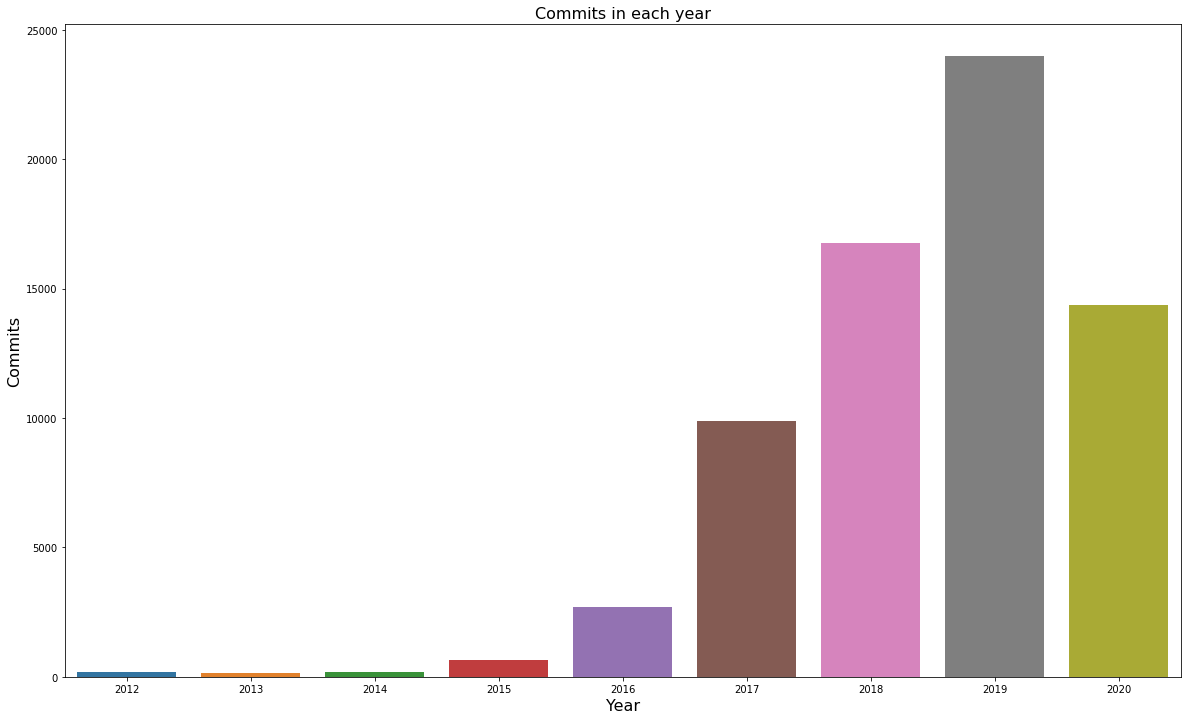

In [ ]:
#@title Commits yearly analysis
commits['Year'] = commits['Date'].apply(lambda x: x.split('-')[0])
yearly_stats = commits.groupby('Year').count()['Commit Id']
plt.figure(figsize = (20, 12))
sns.barplot(yearly_stats.index, yearly_stats.values)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Commits", fontsize = 16)
plt.title("Commits in each year", fontsize = 16)

Text(0.5, 1.0, 'Language distribution amongst all repositories')

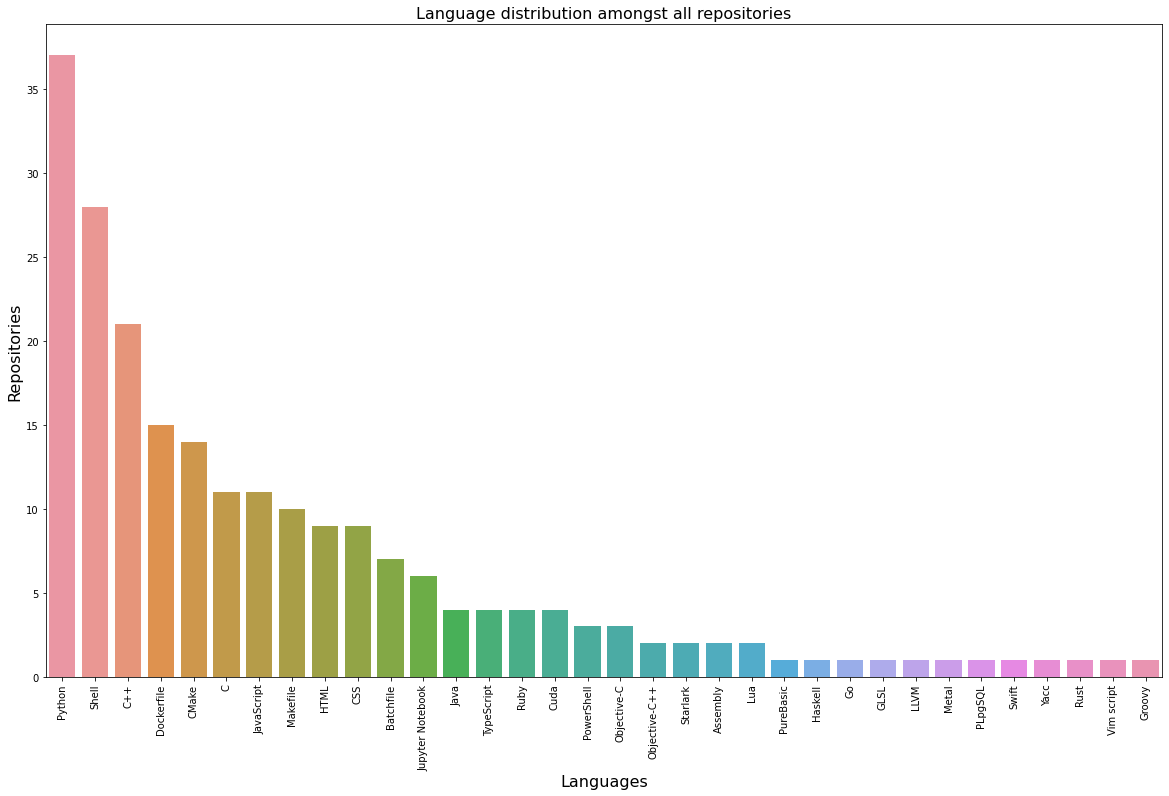

In [ ]:
#@title Language distribution among all repository
list_of_languages = []
for languages in repos['Languages']:
    if type(languages) == str:
        for language in languages.split(','):
            list_of_languages.append(language.strip())

languages_count = pd.Series(list_of_languages).value_counts()
plt.figure(figsize = (20, 12))
sns.barplot(languages_count.index, languages_count.values)
plt.xlabel("Languages", fontsize = 16)
plt.xticks(rotation = 90)
plt.ylabel("Repositories", fontsize = 16)
plt.title("Language distribution amongst all repositories", fontsize = 16)

